In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999

In [2]:
def load_original_data():
    return pd.read_csv("data/Data_Marketing_Customer_Analysis_Round2.csv" )

In [3]:
def clean_data(df):
    df.columns=[e.lower().replace(' ', '_') for e in df.columns]
    df=df.drop(columns=['unnamed:_0', 'vehicle_type',"customer","number_of_open_complaints"])
    df=df.dropna()
    df['effective_to_date']=pd.to_datetime(df['effective_to_date'], errors='coerce')
    df["month"]=list(map(lambda date:date.strftime(format="%B"),df["effective_to_date"]))
    return df

In [4]:
def transform(df):
    df=df[df['income']>0]
    df["total_claim_amount"]=round(df["total_claim_amount"],0)
    df["customer_lifetime_value"]=round(df["customer_lifetime_value"],0)
    df.vehicle_class[customers_df.vehicle_class.isin(["Luxury Car","Luxury SUV"])] = "Luxury Car"
    df.vehicle_class[customers_df.vehicle_class.isin(["Four-Door Car","SUV"])] = "Four-Door Car"
    df.policy[df.policy.isin(["Personal L3","Personal L2","Personal L1"]) ] = "Personal"
    df.policy[df.policy.isin(["Corporate L3","Corporate L2","Corporate L1"]) ] = "Corporate"
    df.policy[df.policy.isin(["Special L3","Special L2","Special L1"]) ] = "Special"
    df=df.drop(columns=["month","education"])
    df.number_of_policies[df.number_of_policies>2]=3
    return df

In [5]:
customers_df=load_original_data()
#customers_df=clean_data(customers_df)
#customers_df=transform(customers_df)

customers_df = (                  
clean_data(customers_df)                 
.pipe(transform) 
)

<ipython-input-4-d81fbe62968f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["total_claim_amount"]=round(df["total_claim_amount"],0)
<ipython-input-4-d81fbe62968f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["customer_lifetime_value"]=round(df["customer_lifetime_value"],0)
<ipython-input-4-d81fbe62968f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [6]:
customers_df.shape

(6817, 21)

In [7]:
customers_df.columns

Index(['state', 'customer_lifetime_value', 'response', 'coverage',
       'effective_to_date', 'employmentstatus', 'gender', 'income',
       'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size'],
      dtype='object')

X-Y split  
splitting the target variable from the dependent variables

In [8]:
X=customers_df.drop('total_claim_amount', axis=1)
y=customers_df.total_claim_amount

# we drop some useless columns
X=X.drop(columns=['effective_to_date'])

Get the numeric data.

In [9]:
numericals =X._get_numeric_data()
# numericals =data.select_dtypes(np.number)
numericals.head()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_policies
0,4809.0,48029,61,7.0,52,3
2,14948.0,22139,100,34.0,31,2
3,22332.0,49078,97,10.0,3,2
6,5035.0,37405,63,8.0,99,3
7,4956.0,87197,63,35.0,45,3


In [11]:
numericals.describe()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_policies
count,6817.000000,6817.000000,6817.000000,6817.000000,6817.000000,6817.000000
mean,8130.234707,50456.580461,92.963034,15.046941,47.832624,2.029925
std,6949.068193,24305.956566,34.615160,10.064762,27.895350,0.865678
min,2120.000000,10037.000000,61.000000,0.000000,0.000000,1.000000
25%,4091.000000,28432.000000,68.000000,6.000000,24.000000,1.000000
50%,5811.000000,48081.000000,83.000000,14.000000,48.000000,2.000000
75%,9076.000000,70187.000000,109.000000,23.000000,71.000000,3.000000
max,83325.000000,99981.000000,297.000000,35.000000,99.000000,3.000000


#### Checking Multicorrelinilaty

                               customer_lifetime_value    income  \
customer_lifetime_value                       1.000000  0.002916   
income                                        0.002916  1.000000   
monthly_premium_auto                          0.399491 -0.012372   
months_since_last_claim                       0.018531 -0.034453   
months_since_policy_inception                 0.011275  0.015799   
number_of_policies                            0.202484  0.009224   

                               monthly_premium_auto  months_since_last_claim  \
customer_lifetime_value                    0.399491                 0.018531   
income                                    -0.012372                -0.034453   
monthly_premium_auto                       1.000000                 0.005887   
months_since_last_claim                    0.005887                 1.000000   
months_since_policy_inception              0.020112                -0.039993   
number_of_policies                        -

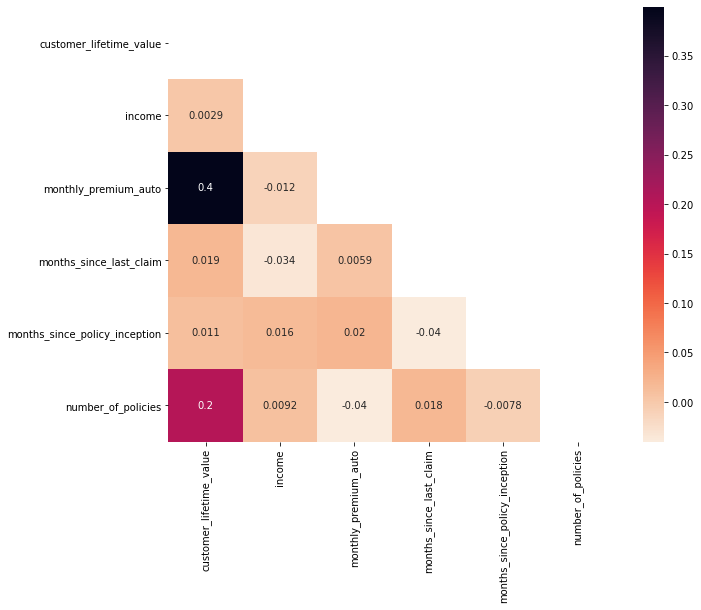

In [12]:
correlations = numericals.corr()
print(correlations)
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(numericals.corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(10, 8))
ax=sns.heatmap(numericals.corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

There is no multicollinearity between the numerical features, highest covarriance is 0.4.

#### Standardize

In [13]:
# Before starting with the linear regression model we standardize the data for better model fit.
X_scaled=StandardScaler().fit_transform(numericals)
X_scaled.shape

(6817, 6)

### Get Categorical data

In [14]:
# Getting categorical data

categoricals_features = X.select_dtypes(object)

### Categorical Variables Transformation

One Hot Encoding

In [15]:
# get dummies pandas
categoricals_features=pd.get_dummies(categoricals_features, drop_first=True)
##pd.DataFrame(OneHotEncoder(drop='first').fit_transform(categoricals_features).toarray(),
## columns=OneHotEncoder(drop='first').fit(categoricals_features).get_feature_names(input_features=categoricals_features.columns)).head()

In [17]:
categoricals_features

,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,employmentstatus_Employed,employmentstatus_Medical Leave,employmentstatus_Retired,gender_M,location_code_Suburban,location_code_Urban,marital_status_Married,marital_status_Single,policy_type_Personal Auto,policy_type_Special Auto,policy_Personal,policy_Special,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0
3,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
7,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
10903,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0
10906,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0
10907,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0


In [18]:
all_features=pd.concat([numericals, categoricals_features], axis=1) # concat numerical and categorical transformations
all_features.head()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_policies,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,employmentstatus_Employed,employmentstatus_Medical Leave,employmentstatus_Retired,gender_M,location_code_Suburban,location_code_Urban,marital_status_Married,marital_status_Single,policy_type_Personal Auto,policy_type_Special Auto,policy_Personal,policy_Special,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,4809.0,48029,61,7.0,52,3,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,14948.0,22139,100,34.0,31,2,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0
3,22332.0,49078,97,10.0,3,2,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
6,5035.0,37405,63,8.0,99,3,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
7,4956.0,87197,63,35.0,45,3,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0


### Train Test Split

In [19]:
X_train, X_test, y_train, y_test=train_test_split(all_features, y, test_size=.20)
X_train

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_policies,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,employmentstatus_Employed,employmentstatus_Medical Leave,employmentstatus_Retired,gender_M,location_code_Suburban,location_code_Urban,marital_status_Married,marital_status_Single,policy_type_Personal Auto,policy_type_Special Auto,policy_Personal,policy_Special,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
5906,36946.0,75425,116,25.0,88,2,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0
7035,8319.0,49734,69,3.0,41,2,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3949,2593.0,57563,66,7.0,61,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
10052,2449.0,40658,61,24.0,79,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0
6830,2629.0,83838,65,1.0,74,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10225,4625.0,28264,61,22.0,12,3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1173,8083.0,53554,67,6.0,5,2,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3472,7124.0,61233,89,27.0,50,3,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0
7964,15886.0,56362,197,30.0,47,3,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0


### Apply Linear Regression

In [20]:
# Linear regression / OLS regression

model=LinearRegression()    # model
model.fit(X_train.to_numpy(), y_train)   # model train

y
y_pred=model.predict(X_test.to_numpy())   # model prediction

y_pred_train=model.predict(X_train.to_numpy())

In [21]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression

dict_classifiers = {
    "Lasso": Lasso(),
    "clf": Ridge(alpha=1.0),
    "elastic_net" : ElasticNet(random_state=0)
} 

def model_check(dict_classifiers):
    for modeltype, model_instantiation in dict_classifiers():
        model=model_instantiation
        model.fit(X_train, y_train)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")
      
#dict_classifiers = {
#    "Logreg": LogisticRegression(solver='lbfgs'),
#    "NN": KNeighborsClassifier(),
#    "LinearSVM": SVC(probability=True, kernel='linear'), #class_weight='balanced'
#    "GBC": GradientBoostingClassifier(),
#    "DT": tree.DecisionTreeClassifier(),
#    "RF": RandomForestClassifier(),
#    "NB": GaussianNB(),
#}

#for model, model_instantiation in dict_classifiers.iteritems():
#     y_score = model_instantiation.fit(X_train, y_train).decision_function(X_test)

In [22]:
dict_classifiers = {
    "Lasso": Lasso(),
    "clf": Ridge(alpha=1.0),
    "elastic_net" : ElasticNet(random_state=0)
}
model_check(dict_classifiers)

TypeError: 'dict' object is not callable

In [26]:
from sklearn.linear_model import Lasso,Ridge,ElasticNet, LinearRegression
model=Lasso()
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

Lasso: Train -> 0.7938222497249461, Test -> 0.8253755810208417


In [31]:
from sklearn.linear_model import Lasso,Ridge,ElasticNet, LinearRegression
model=Lasso()
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")
model=Ridge(alpha=1.0)
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")
model=ElasticNet(random_state=0)
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

Lasso: Train -> 0.7938222497249461, Test -> 0.8253755810208417
Ridge: Train -> 0.7964705282104767, Test -> 0.8252332182386297
ElasticNet: Train -> 0.5820438669901637, Test -> 0.6456784661425442


#### Model Validation

MSE.

In [ ]:
train_mse=mse(y_train,model.predict(X_train.to_numpy()))
test_mse=mse(y_test,model.predict(X_test.to_numpy()))

print ('train MSE: {} -- test MSE: {}'.format(train_mse, test_mse))

RMSE.

In [ ]:
print ('train RMSE: {} -- test RMSE: {}'.format(train_mse**.5, test_mse**.5))

MAE.

In [ ]:
train_mae=mae(y_train,model.predict(X_train.to_numpy()))
test_mae=mae(y_test,model.predict(X_test.to_numpy()))

print ('train MAE: {} -- test MAE: {}'.format(train_mse, test_mse))

R2.

In [ ]:
r2= model.score(X_test.to_numpy(), y_test)
print (r2)

print(r2_score(y_test,model.predict(X_test.to_numpy())))

In [ ]:

print ('train R2: {} -- test R2: {}'.format(model.score(X_train.to_numpy(), y_train),
                                            model.score(X_test.to_numpy(), y_test)))

adjusted rsquare

In [ ]:
N=X_train.shape[0]
p=36
x = (1-r2)
y = (N-1) / (N-p-1)
adj_rsquared = (1 - (x * y))
print("Adjusted-R2 : " , adj_rsquared)

#### Feature Importance

In [ ]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

In [ ]:
## decide on each variable importance on your model using adjusted R_squared 

In [ ]:
features_importances

In [ ]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### evaluating the importance of new variable to my study  
#### pseduo code
for each iteration
    * X_train(including new variable) = 
    * P= number of paramter 
    * new adjusted_R2= compute adjusted_r2 (p)
    * if adjusted_r_squared_with_new_feature <=  adjusted_r_squared_without_new_feature 
        drop the new variable because it is not significant to my study 

In [ ]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(2,2)
ax[0,0].plot(y_pred, y_test, 'o')
ax[0,0].set_xlabel("y_test")
ax[0,0].set_ylabel("y_pred")
ax[0,0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[0,1].hist(y_test - y_pred)
ax[0,1].set_xlabel("Test y-y_pred")
ax[0,1].set_title("Test Set Residual histogram")

ax[1,0].plot(y_pred_train, y_train, 'o')
ax[1,0].set_xlabel("y_train")
ax[1,0].set_ylabel("y_pred_train")
ax[1,0].set_title("Train set Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1,1].hist(y_train - y_pred_train)
ax[1,1].set_xlabel("Train y-y_pred")
ax[1,1].set_title("Train Residual histogram")

# Plotting

EDA Catgorical Columns 

In [ ]:
for c in customers_df.select_dtypes(object):
    plt.figure(figsize=(10,5))
    plt.bar(customers_df[c].unique(), customers_df[c].value_counts())
    plt.title(c)
    plt.show();

### Show a plot of the total number of responses.

In [ ]:
customers_df.customer_lifetime_value.hist()

In [ ]:
sns.countplot('response', data=customers_df)
plt.ylabel('Total number of Response')
plt.show()

### Show a plot of the response rate by the sales channel.

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot('response', hue='sales_channel', data=customers_df)
plt.ylabel('Response by Sales Channel')
plt.show()


### Show a plot of the response rate by the total claim amount.


In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(y='total_claim_amount' , x='response', data=customers_df)
plt.ylabel('Response by Total Claim Amount')
plt.show()


### Show a plot of the response rate by income.


In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(y='income' , x='response', data=customers_df)
plt.ylabel('Response by Income')
plt.show()

# Data Transformation Lab

#### Check normality visually.

In [ ]:
sns.pairplot(customers_df)
plt.show()

In [ ]:
sns.distplot((customers_df['customer_lifetime_value']), bins=20)

In [ ]:
monthly=boxcox(customers_df['customer_lifetime_value'],lmbda=-0.04)

In [ ]:
sns.histplot(monthly)

In [ ]:
sns.distplot((customers_df['monthly_premium_auto']), bins=20)

In [ ]:
pt = PowerTransformer()
monthly=pt.fit_transform(customers_df['monthly_premium_auto'].to_numpy().reshape(-1,1))
sns.displot(monthly)

In [ ]:
monthly,lam=boxcox(customers_df['monthly_premium_auto'])
sns.histplot(monthly)

In [ ]:
qt = QuantileTransformer()
monthly=qt.fit_transform(customers_df['monthly_premium_auto'].to_numpy().reshape(-1,1))
sns.histplot(monthly)

In [ ]:
sns.regplot(x='monthly_premium_auto',y='total_claim_amount', data=customers_df, scatter_kws={"color": "olive"}, line_kws={"color": "black"})